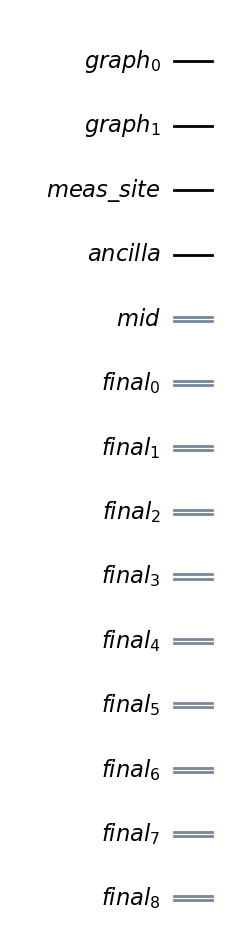

In [26]:
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Qiskit Runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit.circuit.library import MCPhaseGate
import numpy as np
from qiskit.quantum_info import Operator

N = 3
N_tau = 500
t = 3
alpha = 0
jump = 2
N_reg = np.floor(np.log2(N_tau))+1
all = []
for i in range(N):
    all.append(i)

realdim = pow(2,N-1)+1
dim = pow(2,N)


j = np.arange(realdim).reshape(realdim, 1)  # Column vector of indices
k = np.arange(realdim).reshape(1, realdim)  # Row vector of indices
    
    # Compute the exponent matrix
exponent = 2 * np.pi * 1j * j * k / realdim
    
    # Compute Q matrix
DFT = np.exp(exponent) / np.sqrt(realdim)
DFTdag = np.exp(-exponent) / np.sqrt(realdim)


U = np.identity(dim, dtype=complex)
Udag = np.identity(dim, dtype=complex)
# Replace the upper-left 3x3 block with DFT_3
U[:realdim, :realdim] = DFT
Udag[:realdim, :realdim] = DFTdag


U_op = Operator(U)

Udag_op = Operator(Udag)


graph = QuantumRegister(N-1, name="graph")
meas_site = QuantumRegister(1, name="meas_site")
ancilla = QuantumRegister(1, name="ancilla")

mid_measure = ClassicalRegister(1, name="mid")
readout = ClassicalRegister(N_reg, name="final")

qc = QuantumCircuit(graph, meas_site, ancilla, mid_measure, readout)

def trial(qc,graph, meas_site, ancilla, measures, N,jump,dim, realdim,N_tau, t, N_reg, all, N_trials ):
    
    qc.unitary(U_op, all, label='DFT_3')

    eig = []
    for i in range(realdim):
        lam = 0
        for j in range(1,jump+1):
            lam += 2*np.cos(2*np.pi*i*j/realdim+alpha)
        eig.append(lam)


    binary = [0]*N #number written from sx to dx
    for i in range(realdim-1):

        num = i
        for j in reversed(range(N)):
            binary[j] = (num-num%2**j)/2**j
            num = num-binary[j]*2**j
            
        for j in range(N):
            if binary[j] ==0:
                qc.x(j)

        mc_phase_gate = MCPhaseGate(-t*eig[i], num_ctrl_qubits=N-1)
        qc.append(mc_phase_gate,all)

        for j in range(N):
            if binary[j] == 0:
                qc.x(j)

    for i in range(N-1):
        qc.x(i)

    mc_phase_gate = MCPhaseGate(-t*eig[realdim-1], num_ctrl_qubits=N-1)
    qc.append(mc_phase_gate,all)
    for i in range(N-1):
        qc.x(i)

    
    qc.unitary(Udag_op, all, label='inv_DFT_3')
 
    qc.measure(meas_site, mid_measure)
    
    binary_array = [int(bit) for bit in bin(N_trials)[:1:-1]]
    for i in range(len(binary_array)):
        if binary_array[i] ==0:
            qc.measure(ancilla, readout[i])
        else:
            qc.x(ancilla)
            qc.measure(ancilla, readout[i])
            qc.x(ancilla)





#trial(qc,graph, meas_site, ancilla, mid_measure, N,jump,dim, realdim,N_tau, t, N_reg, all,1 )

qc.draw(output="mpl", style='iqp', cregbundle=False)

In [27]:


for k in range(N_tau):
  
    with qc.if_test((mid_measure, 0b1)) as else_:
       
        pass
    with else_:
       
        trial(qc,graph, meas_site, ancilla, mid_measure, N,jump,dim, realdim,N_tau, t, N_reg, all,k+1 )
    


#qc.draw(output="mpl", style='iqp', cregbundle=False)

{'Not Detected': 7502, '16': 1441, '48': 266, '32': 588, '80': 56, '64': 111, '96': 24, '112': 8, '128': 3, '144': 1}


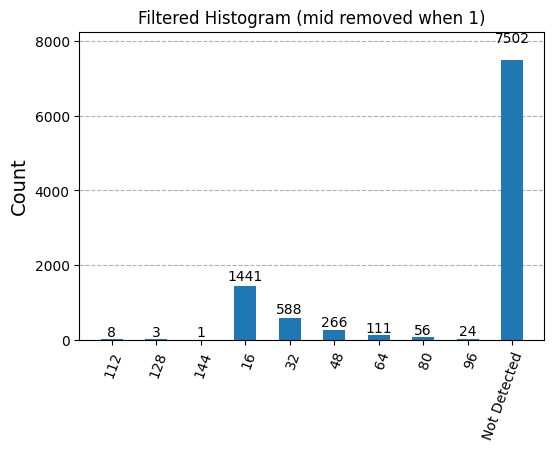

In [ ]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi



# Measure each qubit
#qc.measure(N-1,0)



simulator = AerSimulator()
qc = transpile(qc, simulator)

# Run and get counts
result = simulator.run(qc,shots=10000).result()
#data_final = simulator.run(qc,shots=1000).result()[0].data.readout
counts = result.get_counts(qc)
processed_counts = {"Not Detected": 0}

def reverse_and_convert_to_string(bitstring):
    
    decimal_value = 0
    length = len(bitstring)
    
    # Traverse the string from right to left and convert each bit to decimal
    for i in range(length):
        if bitstring[N- i-1] == '1':
            decimal_value += 2 ** i
            
            
    return str(decimal_value)

not_det = 0

for bitstring, count in counts.items():
    mid_bit = bitstring[-1]  # Extract 'mid' (first classical bit from the right)
    final_bits = bitstring[:-1]  # Extract 'final' (remaining bits)

    if mid_bit == "1":
        final_decimal_str = reverse_and_convert_to_string(final_bits)
        
        processed_counts[final_decimal_str] = processed_counts.get(final_decimal_str, 0) + count
        
        
    else:
        # If mid is '0', add to 'Not Detected'
        processed_counts["Not Detected"] += count
        not_det+= count

    
print(processed_counts)
    # Step 4: Plot the histogram
plot_histogram(processed_counts, title="Filtered Histogram (mid removed when 1)", figsize=(6, 4))



#plot_histogram(counts, title='Bell-State counts')

In [22]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi



# Measure each qubit
#qc.measure(N-1,0)


times_run = 10000
simulator = AerSimulator()
qc = transpile(qc, simulator)

# Run and get counts
result = simulator.run(qc,shots=10000).result()

counts = result.get_counts(qc)

def reverse_and_convert_to_decimal(bitstring):
    
    decimal_value = 0
    length = len(bitstring)
    
    # Traverse the string from right to left and convert each bit to decimal
    for i in range(length):
        if bitstring[N-1- i] == '1':
            decimal_value += 2 ** i
            
            
    return decimal_value

mean_n = 0;

for bitstring, count in counts.items():
    mid_bit = bitstring[-1]  # Extract 'mid' (first classical bit from the right)
    final_bits = bitstring[:-1]  # Extract 'final' (remaining bits)

    if mid_bit == "1":
        final_decimal = reverse_and_convert_to_decimal(final_bits)
        mean_n += count/times_run*final_decimal
       

    
print(mean_n)


70.5169


In [ ]:
a =

In [2]:
print(a)

range(1, 7)


In [ ]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi



# Measure each qubit
#qc.measure(N-1,0)



simulator = AerSimulator()
qc = transpile(qc, simulator)

# Run and get counts
result = simulator.run(qc,shots=10000).result()
#data_final = simulator.run(qc,shots=1000).result()[0].data.readout
counts = result.get_counts(qc)
processed_counts = {"Not Detected": 0}



not_det = 0

for bitstring, count in counts.items():
    mid_bit = bitstring[-1]  # Extract 'mid' (first classical bit from the right)
    
    if mid_bit != "1":
        not_det+= count
        
  

    




#plot_histogram(counts, title='Bell-State counts')